In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *
from frontend import solve, evaluate
import mls as md
import fw

## Warehouse

In [2]:
# X: n*p  W: p*m  Y: n*m
# =======================

# parameters
metadata = {'n':1000, 'm':100, 'p':100, 'r':10, 'nn':1, 'seed':0}
partition = 8  # >= number of cores

# generate data
data, W = md.generate(**metadata)

# prepare data
points = mat2point(*data)
dataRDD = sc.parallelize(points, partition)

## Optimization

In [3]:
# parameter
nn = 1      # trace norm constraint
T = 20
lmo = fw.centralize                                                             # centralize
#lmo = fw.avgmix                                                                 # singular vectors mixture
#lmo = lambda rdd, **kwargs: fw.poweriter(rdd, lambda t: 1, 'random', **kwargs)  # power1
#lmo = lambda rdd, **kwargs: fw.poweriter(rdd, lambda t: 2, 'random', **kwargs)  # power2
#lmo = lambda rdd, **kwargs: fw.poweriter(rdd, lambda t: 1, **kwargs)            # power1 with warm start
#lmo = lambda rdd, **kwargs: fw.poweriter(rdd, lambda t: 2, **kwargs)            # power2 with warm start
#lmo = lambda rdd, **kwargs: fw.poweriter(rdd, lambda t: fw.loground(t, c=1), 'random', **kwargs)  # powlog
step = fw.linesearch

In [4]:
path = solve(dataRDD, metadata, md, nn, T, lmo, step)

## Evaluation

In [5]:
loss, eerr, _ = evaluate(dataRDD, path, metadata, md, W)

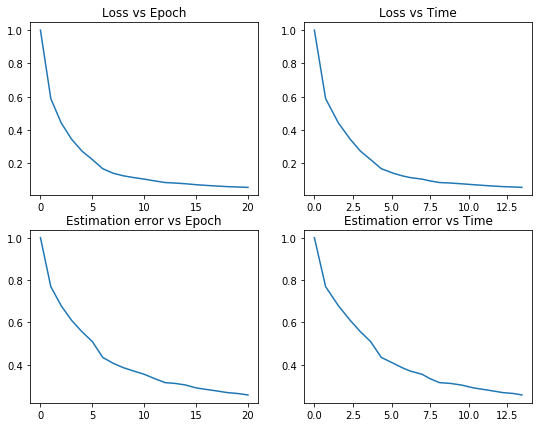

In [6]:
plt.figure(figsize=(9, 7))
plt.subplot(221)
plt.plot(loss)
plt.title('Loss vs Epoch')
plt.subplot(222)
plt.plot(path.timer, loss)
plt.title('Loss vs Time')
plt.subplot(223)
plt.plot(eerr)
plt.title('Estimation error vs Epoch')
plt.subplot(224)
plt.plot(path.timer, eerr)
plt.title('Estimation error vs Time')